In [4]:
import numpy as np
import matplotlib as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap

__Simulated Data Generation:__

The cell below will set parameters to be used when generating the stim_data and stim_responses text files to be used for downstream analysis.

In [6]:
#set parameters for stim_data
stim_interval = 100
dim1_min = 1
dim1_max = 10
dim2_min = 1
dim2_max = 10
action_potential_width = stim_interval // 4  

#set parameters for stim_responses
num_neurons = 100
num_frames = 4000
stim_effect = 10.0
max_response = 20.0

In [8]:
def generate_stim_data():

    #make values for stim onset
    col1 = np.arange(stim_interval, num_frames, stim_interval)

    num_stimuli = len(col1)

    #create random values for dim1 and dim2
    col2 = np.random.randint(dim1_min, dim1_max+1, size=num_stimuli)  # Random integers from 1 to 10
    col3 = np.random.randint(dim2_min, dim2_max+1, size=num_stimuli)  # Random integers from 1 to 10

    #combine
    data = np.column_stack((col1, col2, col3))

    #save
    file_name = "stim_data.txt"
    np.savetxt(file_name, data, delimiter=' ', fmt='%d')

    print(f"File {file_name} has been created with {num_stimuli} stimuli")

generate_stim_data()  

File stim_data.txt has been created with 39 stimuli


In [10]:
def generate_stim_responses(width, amplitude):
    
    ap = np.zeros(width)
    midpoint = width // 2
    
    #make Gaussian-like spike
    for i in range(width):
        ap[i] = amplitude * np.exp(-((i - midpoint) ** 2) / (2 * (width / 6) ** 2))
        
    return ap

#parameters
num_neurons = 100
num_columns = 4000
stimulus_interval = 100
num_stimuli = num_columns // stimulus_interval
no_response_probability = 0.2

#initialize matrix with zeros
matrix = np.zeros((num_neurons, num_columns))

#make aps and insert into matrix
for i in range(1, num_stimuli):
    stimulus_start = i * stimulus_interval
    stimulus_end = stimulus_start + stimulus_interval

    for neuron in range(num_neurons):
        
        if np.random.rand() < no_response_probability:
            # No response for this stimulus
            continue
            
        #create random amplitude and width for each neuron
        amplitude = np.random.uniform(1, 20)  # Random amplitude between 0.5 and 1.0
        width = np.random.randint(5, 50)  # Random width between 10 and 50
        ap = generate_stim_responses(width, amplitude)

        #place ap into matrix
        ap_start = stimulus_start + np.random.randint(0, stimulus_interval - width)
        ap_end = ap_start + width
        matrix[neuron, ap_start:ap_end] += ap

file_name = "stim_responses.txt"
np.savetxt(file_name, matrix, fmt='%.2f')

print(f"File {file_name} has been created for {num_neurons} neurons with {num_columns} responses")

File stim_responses.txt has been created for 100 neurons with 4000 responses


In [14]:
response_data = "./stim_responses.txt"
stim_data = "./stim_data.txt"

In [20]:
def get_responses(response_data, frames, neurons):
    
    with open(response_data, 'r') as file:
        neurons_responses = file.readlines()
        
    neurons_responses_dict = {key:[] for key in range(1, (len(neurons_responses)+1))}

    #append response at each frame for each neuron
    for neuron in range(len(neurons_responses)):
        neurons_responses_dict[neuron+1] = neurons_responses[neuron].strip("\n").split(" ")
        
    for neuron, responses in neurons_responses_dict.items():
        neurons_responses_dict[neuron] = [float(response) for response in responses if response != 'nan']
    
    responses_list = list(iter(neurons_responses_dict.values()))
    
    avg_responses_dict={'N_avg':[] for value in range(frames)}

    #get frame averages column-wise
    for response in range(len(responses_list[0])):
        frame_list = [frame[response] for frame in responses_list] 
        avg_responses_dict['N_avg'].append(sum(frame_list)/len(frame_list)) 

    return neurons_responses_dict, avg_responses_dict
        
neurons_responses_dict, avg_responses_dict = get_responses(response_data, num_frames, num_neurons)

In [22]:
def neural_traces(response_data, stim_data, frames, parameter, neuron):
    
    with open(stim_data) as file:
        stimuli = file.readlines()

    stimuli_list = []
    frames_list = []

    #append list of frames where stimulus occurrence appears
    for i in zip(stimuli):
        stimuli_list.append(i[0].split(" ", 1)[0])
        frames_list.append(i[0].strip("\n").split(" "))

    stimuli_list = [eval(y) for y in stimuli_list] #convert scientific notation to decimals
    stimuli_list.sort()

    param_list = []

    #append values of parameter corresponding to stimulus shown at respective frame
    for i in frames_list:
        if parameter == 'dim1':
            param_list.append(float(i[2]))
        elif parameter == 'dim2':
            param_list.append(float(i[1]))

    if parameter == 'dim1':
        original_cmap = cm.colormaps["Oranges"]
    elif parameter == 'dim2':
        original_cmap = cm.colormaps["Purples"]

    #truncate colorbar
    new_colors = original_cmap(np.linspace(0.2, 1))
    truncated_cmap = LinearSegmentedColormap.from_list('truncated_cmap', new_colors)

    param_list = np.array(param_list) 
    norm = Normalize(0, vmax=param_list.max()) 

    fig, ax = plt.subplots(figsize=(12, 6))
    
    if neuron == 'all':
        ax.plot(range(frames), avg_responses_dict.get("N_avg"), label = "Avg Neural Response")
        plt.title(f"Avg Neural Response")
    else:
        if neuron in neurons_responses_dict.keys():
            ax.plot(range(frames), neurons_responses_dict.get(neuron))
            plt.title(f"Neuron {neuron} Neural Response")
        else:
            print("Neuron not in dictionary. Please choose different neuron")

    for stimulus, param_val in zip(stimuli_list, param_list):
        ax.axvline(x=stimulus, color = truncated_cmap(norm(param_val)), linewidth = "0.5")

    sm = plt.cm.ScalarMappable(cmap=truncated_cmap, norm=norm)
    sm.set_array(param_list)
    cbar = plt.colorbar(sm, ax=ax, label = f'{parameter}')
    plt.xlim(0, frames)
    plt.ylim(0, 20)
    plt.xlabel("Frames")
    plt.ylabel("Response Strength")
    plt.tight_layout()
    #plt.savefig(dataset + "/" + f"neural_trace_all.png")
    
    plt.show()

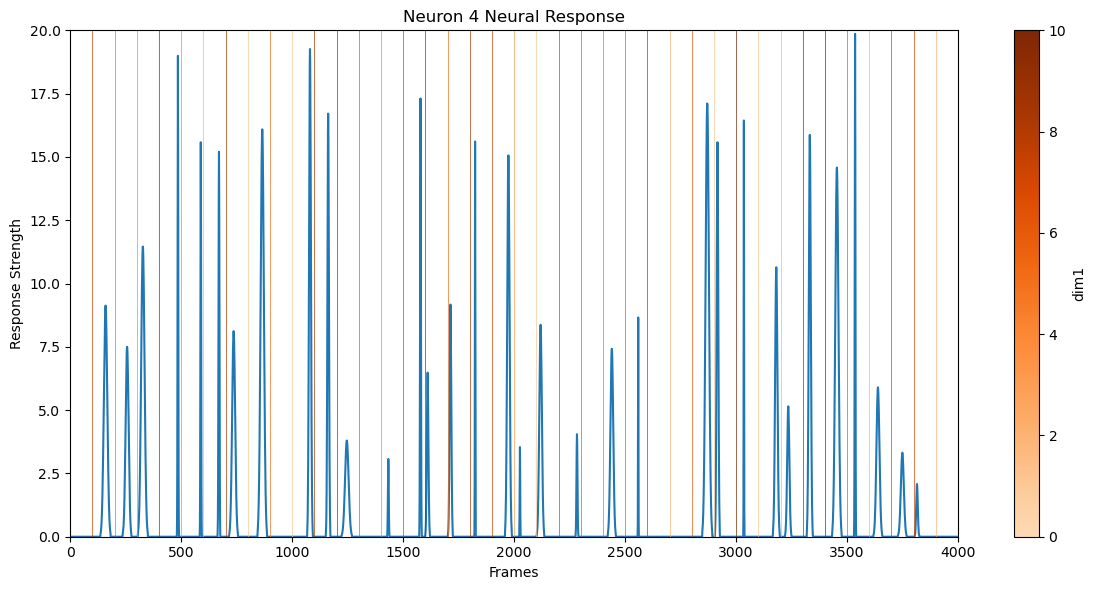

In [28]:
neural_traces(response_data, stim_data, num_frames, "dim1", 4)

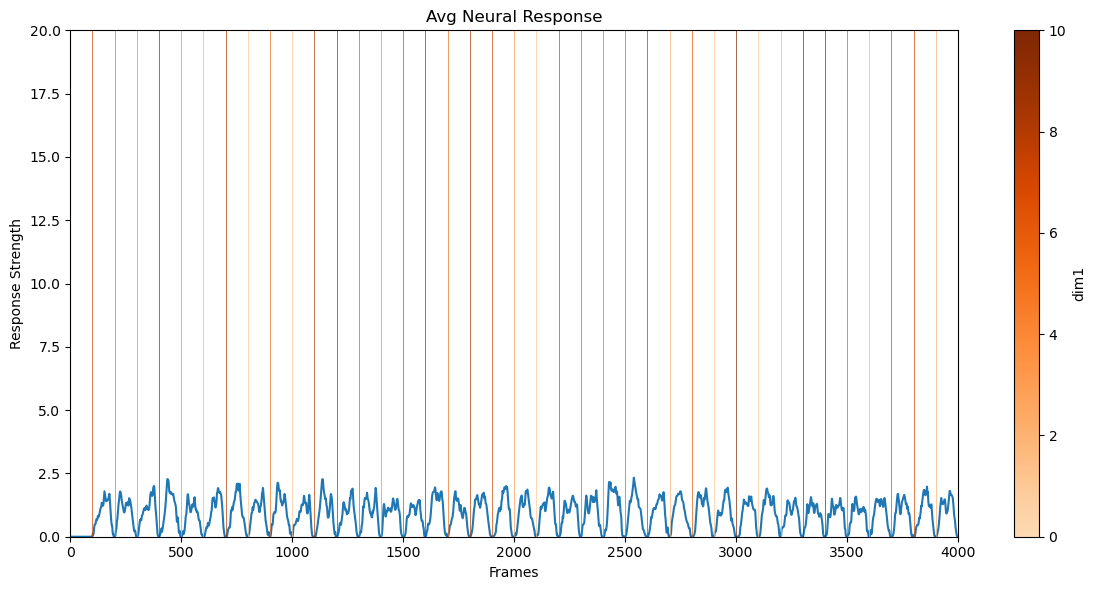

In [30]:
neural_traces(response_data, stim_data, num_frames, "dim1", 'all')